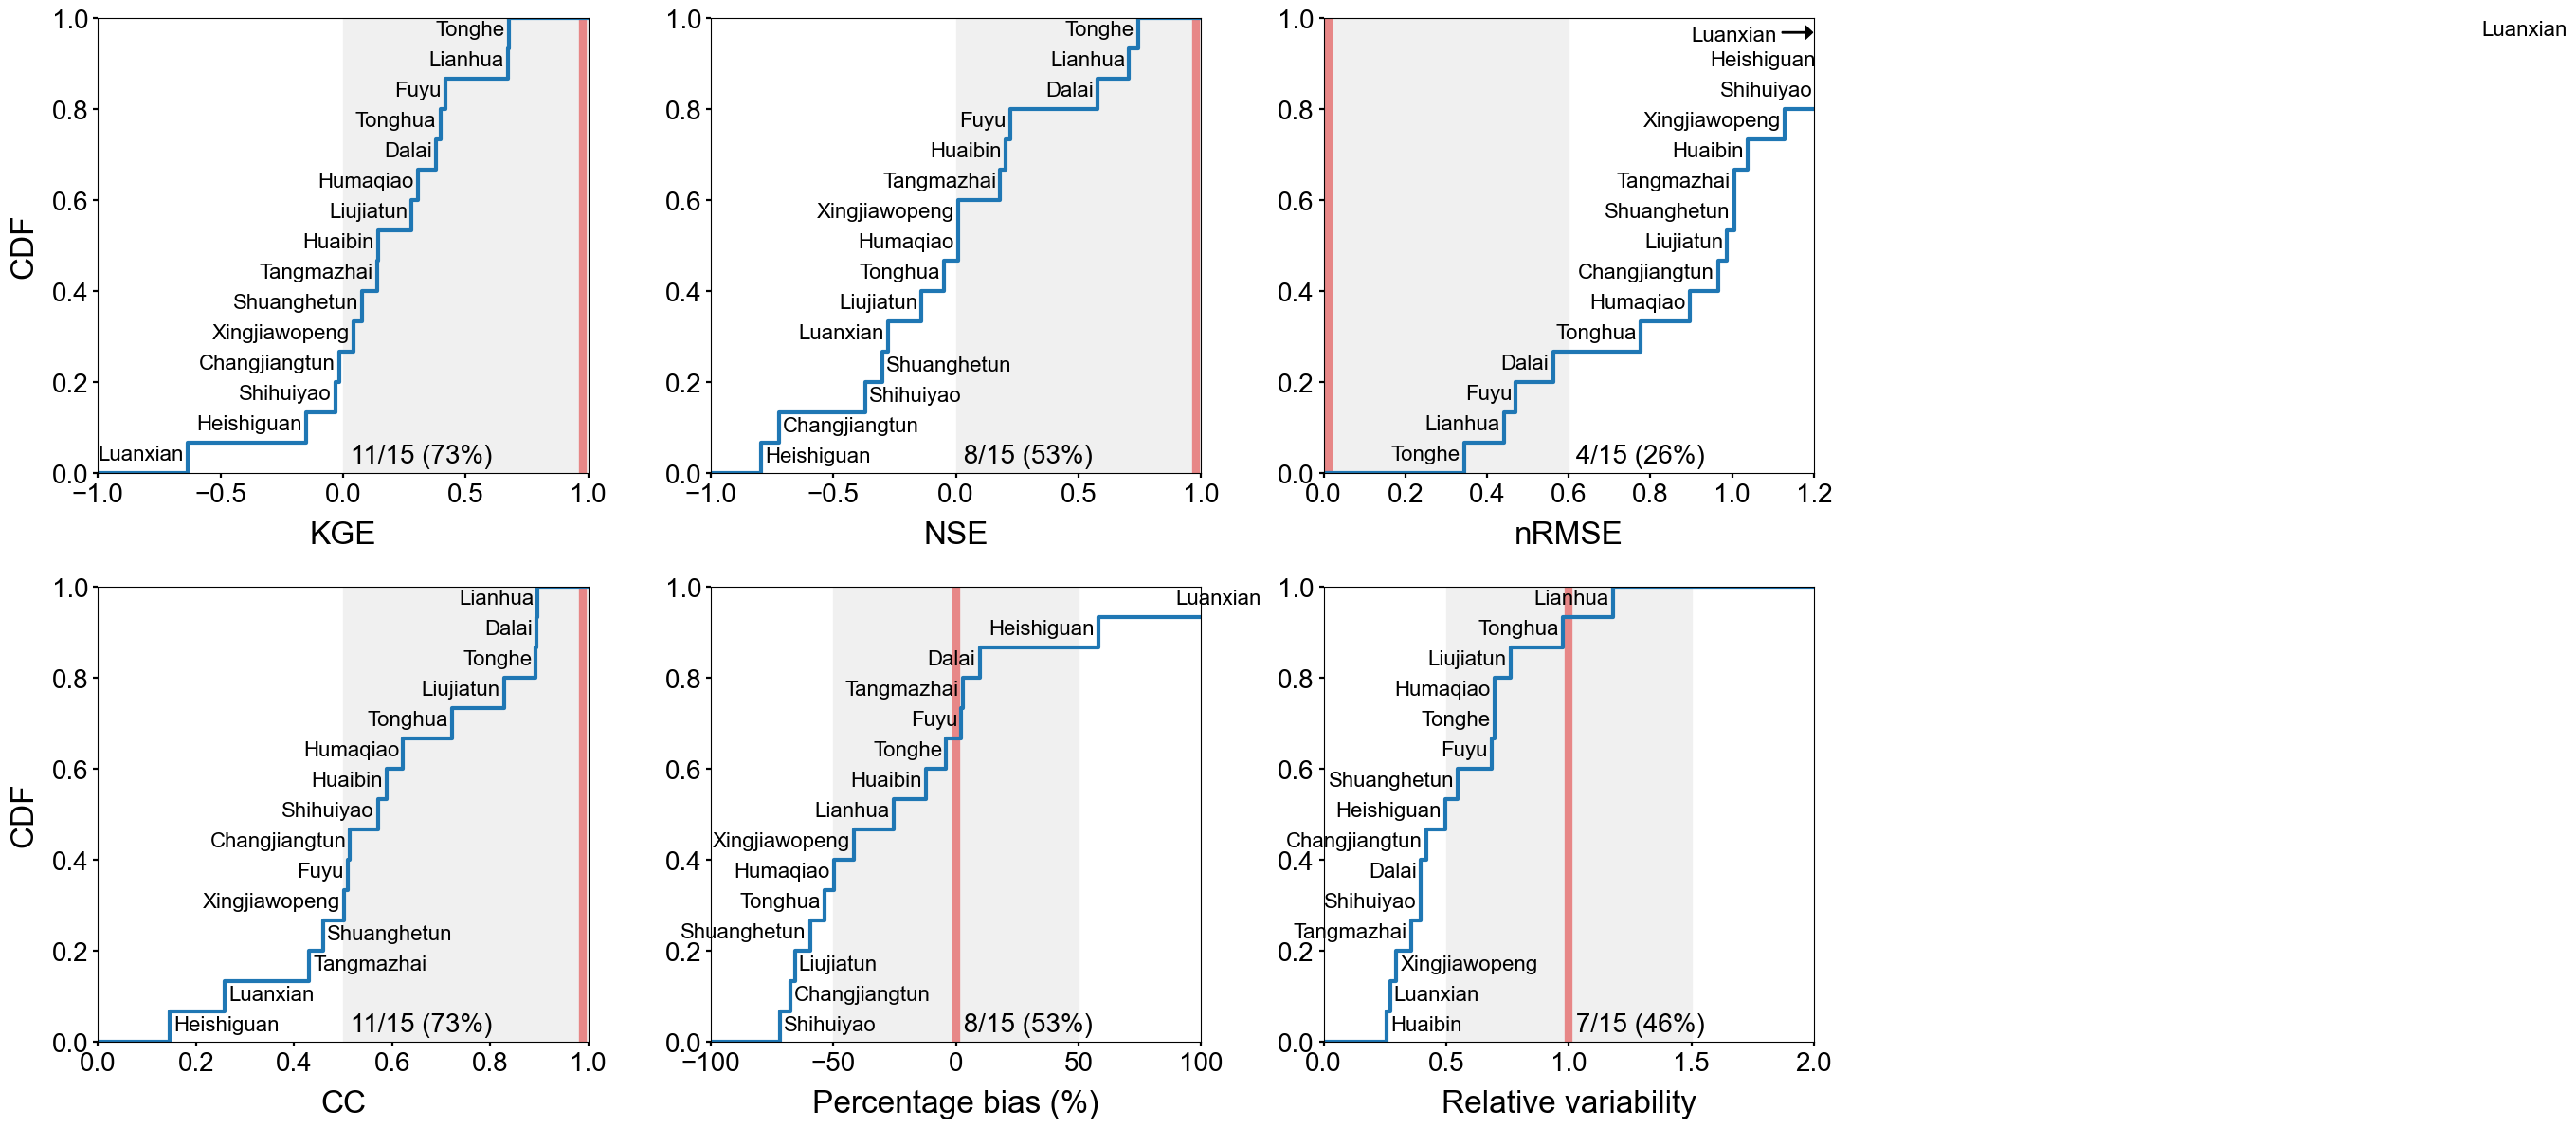

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mpc
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlepad'] = 10
#plt.rcParams['axes.labelpad'] = -2
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.major.width'] = 1.6
#plt.rcParams['axes.facecolor'] = '#F8F8F8'
#plt.rcParams['figure.facecolor'] = '#F8F8F8'

N = 2
M = 3
BOUNDS = [0.1, 0.14, 0.8, 0.8]
MARGIN_LEFT, MARGIN_RIGHT, MARGIN_BOT, MARGIN_TOP = 0.03, 0, 0, 0
subplot_width = (1 - MARGIN_LEFT - MARGIN_RIGHT) / M
subplot_height = (1 - MARGIN_TOP - MARGIN_BOT) / N
AXES_LEFT = MARGIN_LEFT + (np.arange(M) + BOUNDS[0]) * subplot_width
AXES_BOT = MARGIN_BOT + (np.arange(N) + BOUNDS[1]) * subplot_height
AXES_WIDTH = subplot_width * BOUNDS[2]
AXES_HEIGHT = subplot_height * BOUNDS[3]
fig = plt.figure(figsize=(20,12))
ax = [[plt.axes([AXES_LEFT[j], AXES_BOT[i], AXES_WIDTH, AXES_HEIGHT])\
       for j in range(M)] for i in np.arange(N-1,-1,-1)]

def KGE(observed, simulated):
    r = np.corrcoef(observed, simulated)[0, 1]
    alpha = np.mean(simulated) / np.mean(observed)
    beta  = np.std(simulated)/np.mean(simulated) / (np.std(observed)/np.mean(observed))
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

def NSE(observed, simulated):
    return 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)

def nRMSE(observed, simulated):
    rmse = np.sqrt(mean_squared_error(observed, simulated))
    return rmse / np.mean(observed)

def CC(observed, simulated):
    return pearsonr(observed, simulated)[0]  

df_q_all = pd.read_csv('./3-process/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv')
df_q_all = df_q_all[~df_q_all['stationid'].isin(['longmenzhen'])]
df_metrics = pd.read_csv('./4-validation/swot_hypso_metrics.csv')
df_metrics = df_metrics[~df_metrics['stationid'].isin(['longmenzhen'])].set_index('stationid')
stations = sorted(df_q_all['stationid'].unique())

for s in stations:
    df_q = df_q_all[df_q_all['stationid']==s]
    df_q = df_q.sort_values('date')
    df_metrics.loc[s,'CC'] = CC(df_q['qobs'], df_q['Q_est'])
    df_metrics.loc[s,'nRMSE'] = nRMSE(df_q['qobs'], df_q['Q_est'])
    df_metrics.loc[s,'KGE'] = KGE(df_q['qobs'], df_q['Q_est'])
    df_metrics.loc[s,'NSE'] = NSE(df_q['qobs'], df_q['Q_est'])
    df_metrics.loc[s,'pBIAS'] = (df_q['Q_est'].mean() / df_q['qobs'].mean() - 1) * 100
    df_metrics.loc[s,'rv'] = (df_q['Q_est'].std() / df_q['Q_est'].mean()) / (df_q['qobs'].std() / df_q['qobs'].mean())
#df_metrics.to_csv('../3/RSQ_metrics.csv')

cols = ['KGE','NSE','nRMSE','CC','pBIAS','rv']
xlabel = ['KGE','NSE','nRMSE','CC','Percentage bias (%)','Relative variability']
xlim = [(-1,1), (-1,1), (0,1.2), (0,1), (-100,100), (0,2)]
fb_lim = [[0,1], [0,1], [0,0.6], [0.5,1], [-50,50], [0.5,1.5]]
red_line = [1-2e-2, 1-2e-2, 0+1.2e-2, 1-1e-2, 0, 1]
text_right = [-1,3,-1,3,2,2]
text_ratio = [0, 0, 0.6, 0.5, 0, 1]
ax[0][0].set_xticks(np.arange(-1,1.1,0.5))
ax[0][1].set_xticks(np.arange(-1,1.1,0.5))
for panel in range(6):
    i, j = int(panel / M), panel % M
    df_metrics = df_metrics.sort_values(cols[panel])

    x_plot = np.insert(df_metrics[cols[panel]].values, 0, xlim[panel][0]-1)
    within_grey = np.count_nonzero((x_plot>=fb_lim[panel][0]) & (x_plot<=fb_lim[panel][1]))

    ax[i][j].step(x_plot, np.linspace(0,1,len(x_plot)), where='post', color='#1f77b4', lw=3, zorder=1)
    ax[i][j].plot([x_plot[-1],xlim[panel][1]+1], [1,1], color='#1f77b4', lw=3, zorder=1)
    ax[i][j].fill_between(fb_lim[panel], [0,0], [1,1], color='#F0F0F0', zorder=-1)
    ax[i][j].plot([red_line[panel],red_line[panel]], [0,1], color='#E02020', alpha=0.5, lw=6, zorder=0)
    ax[i][j].text(text_ratio[panel], 0.01, ' %d/%d (%d%%)'%(within_grey,len(stations),(within_grey/len(stations)*100)),
                  fontsize=20, ha='left', va='bottom')
    
    ax[i][j].set_xlim(xlim[panel])
    ax[i][j].set_ylim(0,1)
    ax[i][j].set_xlabel(xlabel[panel], labelpad=10)
    if j == 0: ax[i][j].set_ylabel('CDF', labelpad=10)
    

    x0, xmax = ax[i][j].get_xlim()
    y0, ymax = ax[i][j].get_ylim()
    fig_w = xmax - x0
    fig_h = ymax - y0
    for x, y, s, k in zip(x_plot[1:], np.linspace(0,1,len(x_plot))[1:], df_metrics.index, range(len(stations))):
        if panel == 5 and k == 17: continue
        if k <= text_right[panel]:
            ax[i][j].text(x + fig_w*8e-3, y - fig_h*9e-3, s.capitalize(), ha='left', va='top', zorder=0)
        else:
            ax[i][j].text(x - fig_w*8e-3, y - fig_h*5e-3, s.capitalize(), ha='right', va='top', zorder=0)

# # special annotate
# ax[0][0].text(-0.85, 5e-3, 'Luanxian', ha='left', va='bottom')
# ax[0][1].text(-0.85, 5e-3, 'Lianhua', ha='left', va='bottom')
ax[0][2].text(1.85*0.6, 15/16+5e-3, 'Luanxian', ha='right', va='bottom')
# ax[0][2].text(1.85*0.6, 14/16+5e-3, 'Lianhua', ha='right', va='bottom')
# ax[0][2].text(1.85*0.6, 13/16+5e-3, 'Longmenzhen', ha='right', va='bottom')


# ax[1][1].text(85, 17/18+5e-3, 'Luanxian', ha='right', va='bottom')
# ax[1][2].text(1.85, 16/17+5e-3, 'Lianhua', ha='right', va='bottom')

# ax[0][0].arrow(-0.87, 0.5/18, -0.125, 0, width=3e-3, head_width=0.03, head_length=0.03, length_includes_head=True, color='black')
# ax[0][1].arrow(-0.87, 0.5/16, -0.125, 0, width=3e-3, head_width=0.03, head_length=0.03, length_includes_head=True, color='black')
ax[0][2].arrow(1.87*0.6, 15.5/16, 0.125*0.6, 0, width=3e-3, head_width=0.03, head_length=0.03*0.6, length_includes_head=True, color='black')
# ax[0][2].arrow(1.87*0.6, 14.5/16, 0.125*0.6, 0, width=3e-3, head_width=0.03, head_length=0.03*0.6, length_includes_head=True, color='black')
# ax[1][1].arrow(87, 17.5/18, 12.5, 0, width=3e-3, head_width=0.03, head_length=3, length_includes_head=True, color='black')
# ax[1][2].arrow(1.87, 16.5/17, 0.125, 0, width=3e-3, head_width=0.03, head_length=0.03, length_includes_head=True, color='black')


#plt.show()
plt.savefig('Fig7.png', dpi=200)